**Modeling Notebook for**

* Train/Test split
* ML Pipeline creation using Logistic Regression
* Performance metrics like confusion matrix, Accuracy / Precision / Recall / F1 will be used.

In [17]:
import pandas as pd

df_to_sample = pd.read_parquet('../Data/feature_engineered_stroke_data.parquet')
df_to_sample.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67,0,1,Yes,Private,Urban,229,37,formerly smoked,1
1,51676,Female,61,0,0,Yes,Self-employed,Rural,202,29,never smoked,1
2,31112,Male,80,0,1,Yes,Private,Rural,106,32,never smoked,1
3,60182,Female,49,0,0,Yes,Private,Urban,171,34,smokes,1
4,1665,Female,79,1,0,Yes,Self-employed,Rural,174,24,never smoked,1


In [23]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline as ImbPipeline  # important!
from imblearn.over_sampling import SMOTE

#define features and target
X = df_to_sample.drop(columns=['stroke'])
y = df_to_sample['stroke']

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
    )

# Identify columns
numeric_cols = X_train.select_dtypes(include=['int64','float64']).columns
categorical_cols = X_train.select_dtypes(include=['object','category']).columns

# Numerical pipeline (Median Impute)
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

# Categorical pipeline (Most frequent or constant)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first',sparse_output = False))
])

# Combine into ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

# FULL MODEL PIPELINE INCLUDING SMOTE
model_pipeline = ImbPipeline(steps=[
    ('preprocess', preprocessor),
    ('smote', SMOTE(random_state=42,sampling_strategy=0.7)),
    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

# Fit
model_pipeline.fit(X_train, y_train)

#precitions
y_pred = model_pipeline.predict(X_test)
threshold = 0.25
y_pred_proba = model_pipeline.predict_proba(X_test)[:,1]

# Applying predictions on test set

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score,accuracy_score

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred,zero_division = 0))
print("\nROC AUC Score:", roc_auc_score(y_test, y_pred_proba))


Accuracy: 0.5383411580594679

Confusion Matrix:
 [[643 573]
 [ 17  45]]

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.53      0.69      1216
           1       0.07      0.73      0.13        62

    accuracy                           0.54      1278
   macro avg       0.52      0.63      0.41      1278
weighted avg       0.93      0.54      0.66      1278


ROC AUC Score: 0.6960420203735145


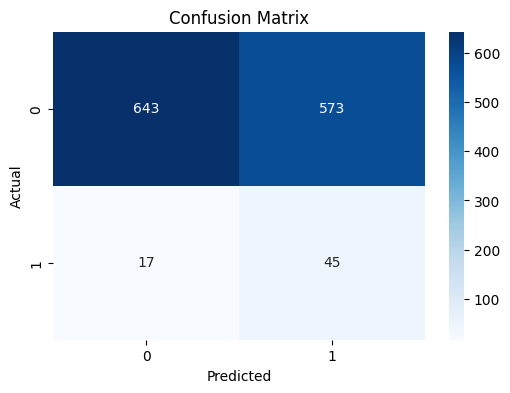

In [26]:
# plotting the performance metrics
import matplotlib.pyplot as plt
import seaborn as sns
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig('../Images/confusion_matrix_Log_Reg.png',bbox_inches='tight',dpi = 300)
plt.show()



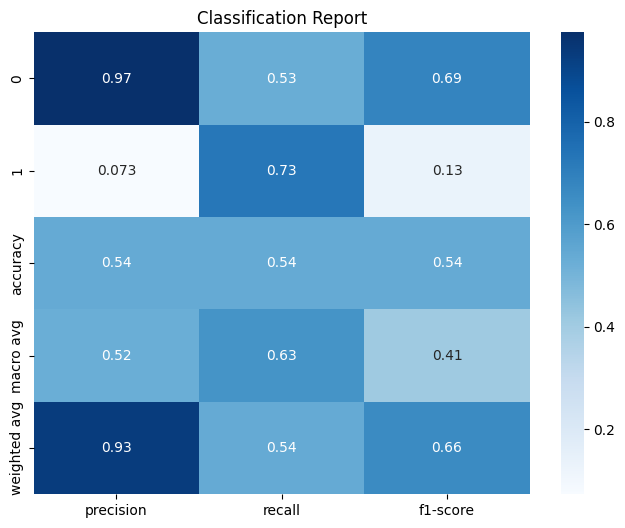

In [27]:
# plot classfication report
report = classification_report(y_test, y_pred, output_dict=True)
plt.figure(figsize=(8,6))
sns.heatmap(pd.DataFrame(report).iloc[:-1, :].T, annot=True, cmap='Blues')
plt.title('Classification Report')
plt.savefig('../Images/classfication_report_Log_Reg.png',bbox_inches='tight',dpi = 300)
plt.show()


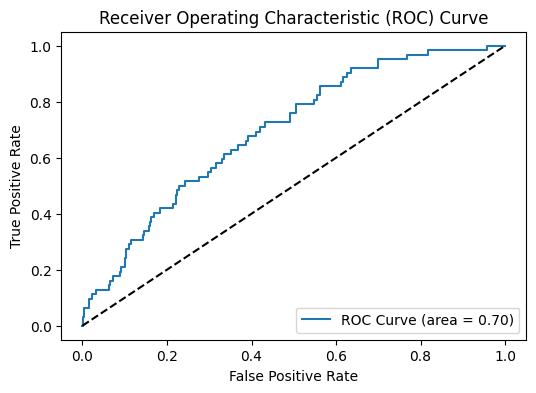

In [30]:
#line plot of roc curve
from pyexpat import model
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, model_pipeline.predict_proba(X_test)[:,1])
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label='ROC Curve (area = %0.2f)' % roc_auc_score(y_test, model_pipeline.predict_proba(X_test)[:, 1]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.savefig('../Images/roc_curve__Log_Reg.png',bbox_inches='tight',dpi = 300)
plt.show()

**Using a sampling strategy of 1:1 between train and test data samples.**

Logistic regression does not seem powerful enough for this task. The low F1 score (13%) for predicitng strokes is low.

Precision score for 1 is 11%, meaning most predictive strokes are false positives.

**Tuning the minority upsampling does not improve the performance - the test set is small for the minority class (1).**

**It is better to try stronger classifier like Random Forest - which are known to handle small imbalanced datasets better**

In [9]:
#Reloading the cleaned data
df = pd. read_parquet('../Data/feature_engineered_stroke_data.parquet')
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67,0,1,Yes,Private,Urban,229,37,formerly smoked,1
1,51676,Female,61,0,0,Yes,Self-employed,Rural,202,29,never smoked,1
2,31112,Male,80,0,1,Yes,Private,Rural,106,32,never smoked,1
3,60182,Female,49,0,0,Yes,Private,Urban,171,34,smokes,1
4,1665,Female,79,1,0,Yes,Self-employed,Rural,174,24,never smoked,1


Accuracy: 0.9460093896713615

Confusion Matrix:
 [[1208    8]
 [  61    1]]

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.99      0.97      1216
           1       0.11      0.02      0.03        62

    accuracy                           0.95      1278
   macro avg       0.53      0.50      0.50      1278
weighted avg       0.91      0.95      0.93      1278


ROC AUC Score: 0.6441598578098472


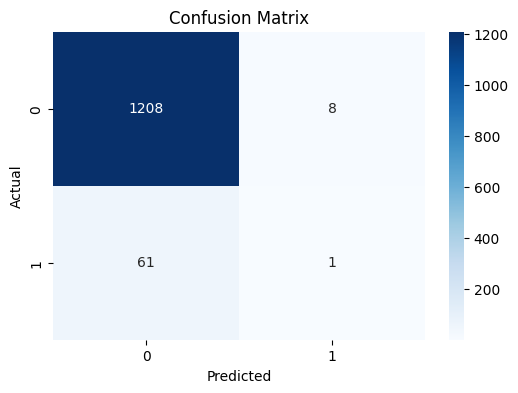

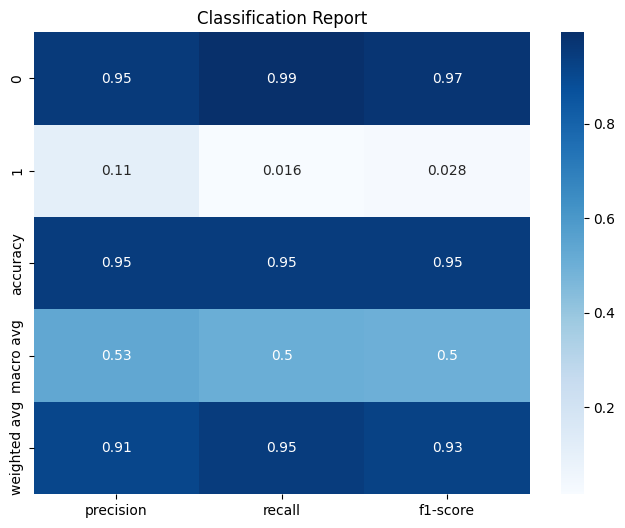

In [37]:
from sklearn.ensemble import RandomForestClassifier as RandomForest


# Full Pipeline with SMOTE + Random Forest
rf_pipeline = ImbPipeline(steps=[
    ('preprocess', preprocessor),
    ('smote', SMOTE(random_state=42,sampling_strategy=0.5)),
    ('clf', RandomForest(
        n_estimators=200,
        max_depth=10,
        min_samples_split=2,
        min_samples_leaf=2,
        random_state=42,
        class_weight='balanced'
        ))
])

# Fit the model on the training data
rf_pipeline.fit(X_train, y_train)

# Predictions
y_pred_proba = rf_pipeline.predict_proba(X_test)[:,1]
threshold = 0.25
y_pred = rf_pipeline.predict(X_test)

# Applying predictions on test set
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score,accuracy_score
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred,zero_division=0))
print("\nROC AUC Score:", roc_auc_score(y_test, y_pred_proba))

# plotting the performance metrics
import matplotlib.pyplot as plt
import seaborn as sns
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig('../Images/confusion_matrix_rf.png', bbox_inches='tight',dpi = 300)
plt.show()

# plot classfication report
report = classification_report(y_test, y_pred, output_dict=True)
plt.figure(figsize=(8,6))
sns.heatmap(pd.DataFrame(report).iloc[:-1, :].T, annot=True, cmap='Blues')
plt.title('Classification Report')
plt.savefig('../Images/classification_report_rf.png', bbox_inches='tight',dpi = 300)
plt.show()


### Random Forest is performing better in overall accuracy compared to Logical regression

* However, it is stsill failing on the minority class.
* 50 samples in the minority class, so any small error drops recall and F1 massively.

* I will tune the Random Forest hyperparameters
* I will see if increeasing the test sample size helps or not

In [34]:
#Tuning the hyperparameters of Random Forest using GridSearchCV
from sklearn.model_selection import GridSearchCV

param_grid = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [None, 10, 20],
    'clf__min_samples_split': [2, 5],
    'clf__min_samples_leaf': [1, 2],
    'clf__class_weight': ['balanced']
}

grid_search = GridSearchCV(
    estimator=rf_pipeline,
    param_grid=param_grid,
    cv=3,                # 3-fold cross-validation
    n_jobs=-1,          # Use all available cores
    scoring='f1',       # Optimize for F1 score
    verbose=2          # Verbosity level
)

grid_search.fit(X_train, y_train)
# Evaluate the best model from grid search
best_rf_model = grid_search.best_estimator_
y_pred = best_rf_model.predict(X_test)
y_pred_proba = best_rf_model.predict_proba(X_test)[:,1]
print("Best Parameters:", grid_search.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nROC AUC Score:", roc_auc_score(y_test, y_pred_proba))


Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best Parameters: {'clf__class_weight': 'balanced', 'clf__max_depth': 20, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 200}
Accuracy: 0.9209702660406885

Confusion Matrix:
 [[1173   43]
 [  58    4]]

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.96      0.96      1216
           1       0.09      0.06      0.07        62

    accuracy                           0.92      1278
   macro avg       0.52      0.51      0.52      1278
weighted avg       0.91      0.92      0.92      1278


ROC AUC Score: 0.6463019949066213


In [35]:
#Finding an optimal threshold for classification

thresholds = [0.5, 0.3, 0.25, 0.2]

for thresh in thresholds:
    y_pred_adjusted = (y_pred_proba >= thresh).astype(int)
    print(f"\nThreshold = {thresh}")
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_adjusted))
    print(classification_report(y_test, y_pred_adjusted, digits=3))
    print("ROC AUC:", roc_auc_score(y_test, y_pred_proba))


Threshold = 0.5
Confusion Matrix:
 [[1172   44]
 [  58    4]]
              precision    recall  f1-score   support

           0      0.953     0.964     0.958      1216
           1      0.083     0.065     0.073        62

    accuracy                          0.920      1278
   macro avg      0.518     0.514     0.516      1278
weighted avg      0.911     0.920     0.915      1278

ROC AUC: 0.6463019949066213

Threshold = 0.3
Confusion Matrix:
 [[1153   63]
 [  55    7]]
              precision    recall  f1-score   support

           0      0.954     0.948     0.951      1216
           1      0.100     0.113     0.106        62

    accuracy                          0.908      1278
   macro avg      0.527     0.531     0.529      1278
weighted avg      0.913     0.908     0.910      1278

ROC AUC: 0.6463019949066213

Threshold = 0.25
Confusion Matrix:
 [[1139   77]
 [  52   10]]
              precision    recall  f1-score   support

           0      0.956     0.937     0.946  

### Finalize model code, ensure pipeline works and save to file for deployment

* Reload feature enginnered parquet file
 
* Train/Test Split

* Full Pipeline creation

* Performance metric and visualisations

Accuracy: 0.8990610328638498

Confusion Matrix:
 [[1139   77]
 [  52   10]]

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.94      0.95      1216
           1       0.11      0.16      0.13        62

    accuracy                           0.90      1278
   macro avg       0.54      0.55      0.54      1278
weighted avg       0.92      0.90      0.91      1278


ROC AUC Score: 0.6463019949066213


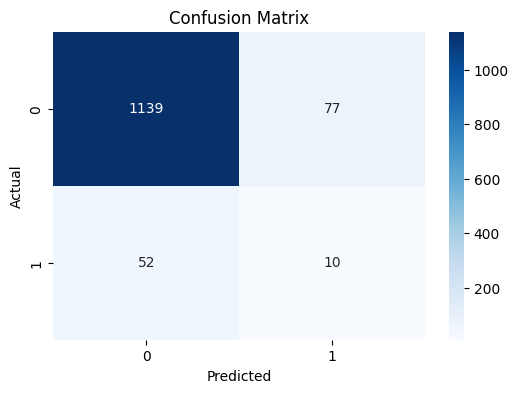

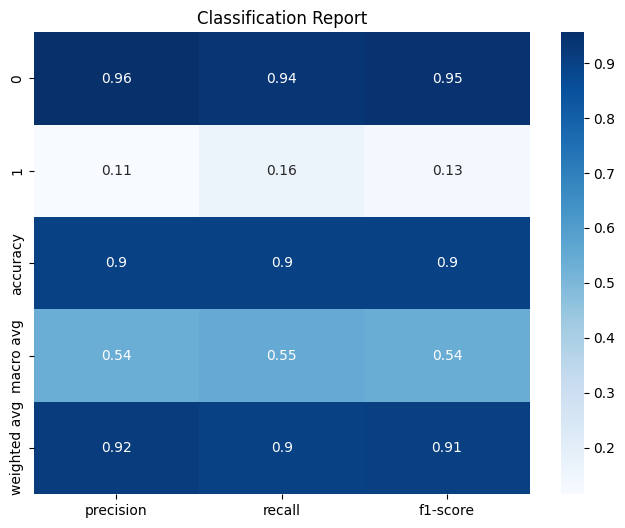

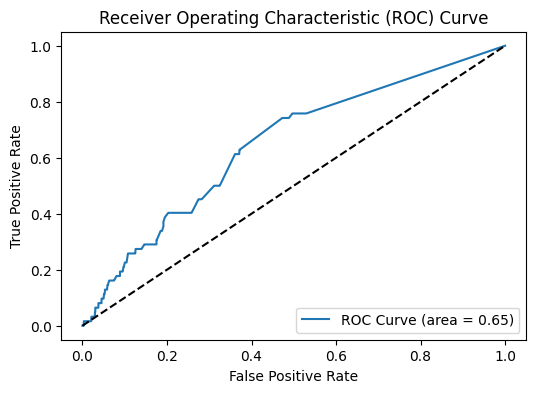

In [43]:
#Reloading the cleaned data
df = pd. read_parquet('../Data/feature_engineered_stroke_data.parquet')

#Define features and targets and then train test split
X = df.drop(columns=['stroke'])
y = df['stroke']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
    )


# Identify columns
numeric_cols = X_train.select_dtypes(include=['int64','float64']).columns
categorical_cols = X_train.select_dtypes(include=['object','category']).columns

# Numerical pipeline (Median Impute)
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])  
# Categorical pipeline (Most frequent or constant)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

# Combine into ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

# Full Pipeline with SMOTE + Random Forest
final_model_pipeline = ImbPipeline(steps=[
    ('preprocess', preprocessor),
    ('smote', SMOTE(random_state=42,sampling_strategy=0.5)),
    ('clf', RandomForest(
        n_estimators=200,
        min_samples_split=2,
        min_samples_leaf=1,
        max_depth=20,
        random_state=42,
        class_weight='balanced'
        ))
])

# Fit the model on the training data
final_model_pipeline.fit(X_train, y_train)

# Prediction Pronabilities
y_pred = final_model_pipeline.predict(X_test)
y_pred_proba = final_model_pipeline.predict_proba(X_test)[:,1]

#Threshold adjustment

threshold = 0.25
y_pred = (y_pred_proba >= threshold).astype(int)

# Applying predictions on test set
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score,accuracy_score
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nROC AUC Score:", roc_auc_score(y_test, y_pred_proba))

# plotting the performance metrics
import matplotlib.pyplot as plt
import seaborn as sns
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig('../Images/final_confusion_matrix.png',bbox_inches = 'tight',dpi = 300)
plt.show()

# plot classfication report
report = classification_report(y_test, y_pred, output_dict=True)
plt.figure(figsize=(8,6))
sns.heatmap(pd.DataFrame(report).iloc[:-1, :].T, annot=True, cmap='Blues')
plt.title('Classification Report')
plt.savefig('../Images/final_classification_report.png',bbox_inches = 'tight',dpi = 300)
plt.show()

# plot roc score
fpr, tpr, thresholds = roc_curve(y_test, final_model_pipeline.predict_proba(X_test)[:,1])
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label='ROC Curve (area = %0.2f)' % roc_auc_score(y_test, final_model_pipeline.predict_proba(X_test)[:, 1]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.savefig('../Images/roc_curve__Log_Reg.png',bbox_inches='tight',dpi = 300)
plt.show()



In [ ]:
#Save the final model
import joblib
joblib.dump(final_model_pipeline, '../Model/final_stroke_prediction_model.pkl')

df.to_parquet('../Data/feature_engineered_stroke_data.parquet', index=False)





['../Model/final_stroke_prediction_model.pkl']